# Washington State Electric Vehicle Registrations Exploratory Data Analysis

#### This dataset is for all electric vehicles (plug-in hybrid or battery electric are currently registered in the state of Washington from 1997 to 2024. (Does not encompass entire United States unfortunately)
- So this makes it a bit tricky since there is no purchase date, can mostly use the model year as a proxy for when the car went into service.
- 

### Some Data Science Questions

Leigh
- Is the rate of growth of electric cars changing? (model year registration, number of models per model year)
- What is the change in the average range per year? Per Manufactuer?

Michael
- Compare sales of electric cars across Washington state Make color coded map by county?


In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import contextily as ctx
import geopandas as gpd

In [33]:
# Loading data
df = pd.read_csv('./data/us_car_data.csv')
df.head()

,County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,CAFV,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Electric Utility,2020 Census Tract,Longitude,latitude
0,Thurston,Tumwater,WA,98512,2019,TESLA,MODEL 3,Battery Electric Vehicle,Clean Alternative Fuel Vehicle Eligible,220,0,22,242565116,PUGET SOUND ENERGY INC,53067010910,-122.913102,47.013593
1,Island,Clinton,WA,98236,2022,NISSAN,LEAF,Battery Electric Vehicle,Eligibility unknown as battery range has not b...,0,0,10,183272785,PUGET SOUND ENERGY INC,53029972000,-122.359364,47.979655
2,Snohomish,Snohomish,WA,98290,2020,TESLA,MODEL 3,Battery Electric Vehicle,Clean Alternative Fuel Vehicle Eligible,266,0,44,112552366,PUGET SOUND ENERGY INC,53061052502,-122.091505,47.915555
3,King,Seattle,WA,98134,2020,TESLA,MODEL 3,Battery Electric Vehicle,Clean Alternative Fuel Vehicle Eligible,322,0,11,6336319,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),53033009300,-122.329815,47.579810
4,Snohomish,Edmonds,WA,98020,2013,TESLA,MODEL S,Battery Electric Vehicle,Clean Alternative Fuel Vehicle Eligible,208,69900,21,186212960,PUGET SOUND ENERGY INC,53061050403,-122.375070,47.808070


In [3]:
df.columns

Index(['County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model',
       'Electric Vehicle Type', 'CAFV', 'Electric Range', 'Base MSRP',
       'Legislative District', 'DOL Vehicle ID', 'Electric Utility',
       '2020 Census Tract', 'Longitude', 'latitude'],
      dtype='object')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134474 entries, 0 to 134473
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   County                 134474 non-null  object 
 1   City                   134474 non-null  object 
 2   State                  134474 non-null  object 
 3   Postal Code            134474 non-null  int64  
 4   Model Year             134474 non-null  int64  
 5   Make                   134474 non-null  object 
 6   Model                  134474 non-null  object 
 7   Electric Vehicle Type  134474 non-null  object 
 8   CAFV                   134474 non-null  object 
 9   Electric Range         134474 non-null  int64  
 10  Base MSRP              134474 non-null  int64  
 11  Legislative District   134474 non-null  int64  
 12  DOL Vehicle ID         134474 non-null  int64  
 13  Electric Utility       134474 non-null  object 
 14  2020 Census Tract      134474 non-nu

In [4]:
# Remove columns that aren't useful to simplify data exploration
df = df.drop(['DOL Vehicle ID', 'Electric Utility', 'CAFV', 'State' ], axis=1)
df.head()

,County,City,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Legislative District,2020 Census Tract,Longitude,latitude
0,Thurston,Tumwater,98512,2019,TESLA,MODEL 3,Battery Electric Vehicle,220,0,22,53067010910,-122.913102,47.013593
1,Island,Clinton,98236,2022,NISSAN,LEAF,Battery Electric Vehicle,0,0,10,53029972000,-122.359364,47.979655
2,Snohomish,Snohomish,98290,2020,TESLA,MODEL 3,Battery Electric Vehicle,266,0,44,53061052502,-122.091505,47.915555
3,King,Seattle,98134,2020,TESLA,MODEL 3,Battery Electric Vehicle,322,0,11,53033009300,-122.329815,47.579810
4,Snohomish,Edmonds,98020,2013,TESLA,MODEL S,Battery Electric Vehicle,208,69900,21,53061050403,-122.375070,47.808070



-Lots of redundant location data -> Should try to utilize that for an interesting map

-The price data seems to be mostly 0s, so that column will not be relevant to look into further

-Columns of interest seem to be `Model Year`, `Make`, `Model`, `Electric Vehicle Type`, `Electric Range`, and
the various location data columns.


In [5]:
# Subsetted dataframe to only BEVs for some analysis
bev_df = df[df['Electric Vehicle Type'] == 'Battery Electric Vehicle   ']
bev_df.head()


,County,City,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Legislative District,2020 Census Tract,Longitude,latitude
0,Thurston,Tumwater,98512,2019,TESLA,MODEL 3,Battery Electric Vehicle,220,0,22,53067010910,-122.913102,47.013593
1,Island,Clinton,98236,2022,NISSAN,LEAF,Battery Electric Vehicle,0,0,10,53029972000,-122.359364,47.979655
2,Snohomish,Snohomish,98290,2020,TESLA,MODEL 3,Battery Electric Vehicle,266,0,44,53061052502,-122.091505,47.915555
3,King,Seattle,98134,2020,TESLA,MODEL 3,Battery Electric Vehicle,322,0,11,53033009300,-122.329815,47.579810
4,Snohomish,Edmonds,98020,2013,TESLA,MODEL S,Battery Electric Vehicle,208,69900,21,53061050403,-122.375070,47.808070


In [6]:
# No Missing Data in dataframe
df.isnull().sum()

County                   0
City                     0
Postal Code              0
Model Year               0
Make                     0
Model                    0
Electric Vehicle Type    0
Electric Range           0
Base MSRP                0
Legislative District     0
2020 Census Tract        0
Longitude                0
latitude                 0
dtype: int64

## Looking at how the number of models is changing with Model Year (Showing growth in variety)

In [7]:
count_per_model_year=df['Model Year'].value_counts().sort_index()

Text(20.347222222222214, 0.5, 'Number of Cars Registered')

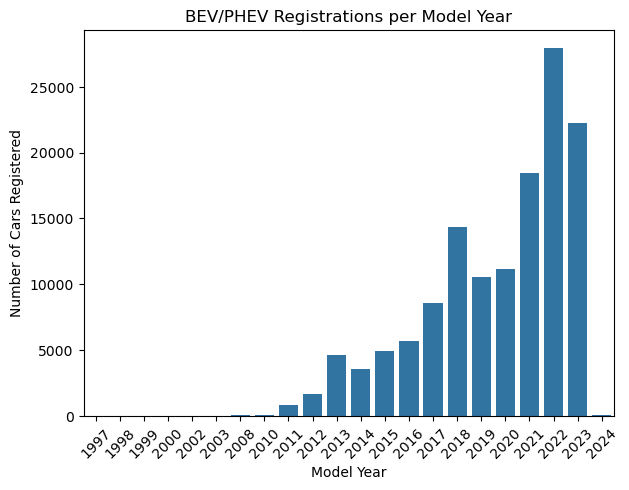

In [58]:
sns.barplot(data=count_per_model_year)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('BEV/PHEV Registrations per Model Year')
plt.ylabel('Number of Cars Registered')

## Might be more interesting to look at manufacturer per year

In [53]:
# Groupby year and make with count. then unstack to pivot out of the series into a dataframe
manufacturer_per_year = df.groupby(['Model Year', 'Make']).size().unstack()
print(manufacturer_per_year)

Make         AUDI  AZURE DYNAMICS  BENTLEY     BMW  CADILLAC  CHEVROLET  \
Model Year                                                                
1997          NaN             NaN      NaN     NaN       NaN        1.0   
1998          NaN             NaN      NaN     NaN       NaN        NaN   
1999          NaN             NaN      NaN     NaN       NaN        NaN   
2000          NaN             NaN      NaN     NaN       NaN        NaN   
2002          NaN             NaN      NaN     NaN       NaN        NaN   
2003          NaN             NaN      NaN     NaN       NaN        NaN   
2008          NaN             NaN      NaN     NaN       NaN        NaN   
2010          NaN             NaN      NaN     NaN       NaN        NaN   
2011          NaN             5.0      NaN     NaN       NaN       75.0   
2012          NaN             3.0      NaN     NaN       NaN      479.0   
2013          NaN             NaN      NaN     NaN       NaN      799.0   
2014          NaN        

In [39]:
# Stacked bar Chart is too messy, select the top 15 makes by total count
# sum counts along column
total_counts = manufacturer_per_year.sum(axis=0)
# count top 15 makes in the total_count series and return the names
top_makes = total_counts.nlargest(min(15, len(total_counts))).index
print(top_makes)

Index(['TESLA', 'NISSAN', 'CHEVROLET', 'FORD', 'BMW', 'KIA', 'TOYOTA',
       'VOLKSWAGEN', 'VOLVO', 'AUDI', 'JEEP', 'HYUNDAI', 'CHRYSLER', 'RIVIAN',
       'PORSCHE'],
      dtype='object', name='Make')


In [40]:
# Create subsetted dataframe only of top 15 makes
top_makes_df = manufacturer_per_year[top_makes]
# Make a new column - Other that combines all the other makes together, sum across rows
top_makes_df['Other'] = manufacturer_per_year.drop(columns=top_makes).sum(axis=1)
top_makes_df.head()

/var/folders/d3/3fhlv1gn0k73glsv1lv807fc0000gn/T/ipykernel_87466/3123859951.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_makes_df['Other'] = manufacturer_per_year.drop(columns=top_makes).sum(axis=1)


Make,TESLA,NISSAN,CHEVROLET,FORD,BMW,KIA,TOYOTA,VOLKSWAGEN,VOLVO,AUDI,JEEP,HYUNDAI,CHRYSLER,RIVIAN,PORSCHE,Other
Model Year,,,,,,,,,,,,,,,,
1997,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1998,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1999,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2000,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2002,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


<Axes: xlabel='Model Year'>

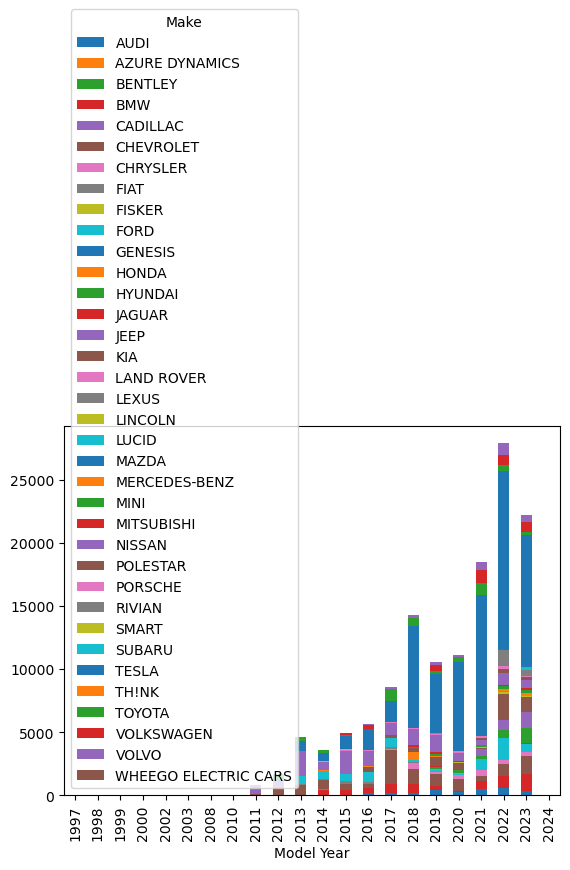

In [37]:
manufacturer_per_year.plot(kind='bar', stacked='True')

<Axes: xlabel='Model Year'>

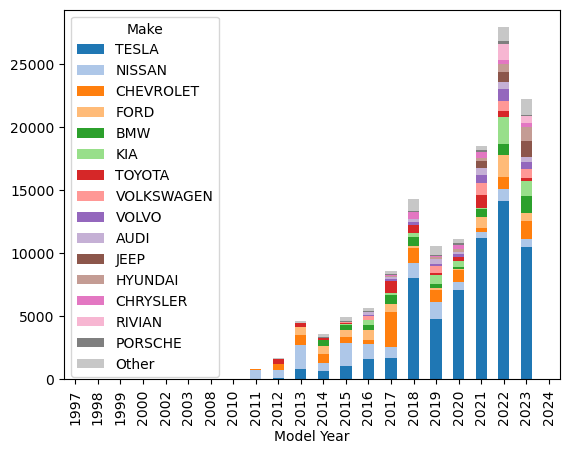

In [54]:
# Better Plot with the top 15 and the Other category
colors = sns.color_palette("tab20", n_colors=len(top_makes_df.columns))
cmap = ListedColormap(colors)
top_makes_df.plot(kind='bar', stacked=True, colormap=cmap)

In [35]:
unique_model_per_year = df.groupby('Model Year')['Model'].nunique()

Text(0.5, 1.0, 'Unique BEV/PHEV Car Models per Model Year')

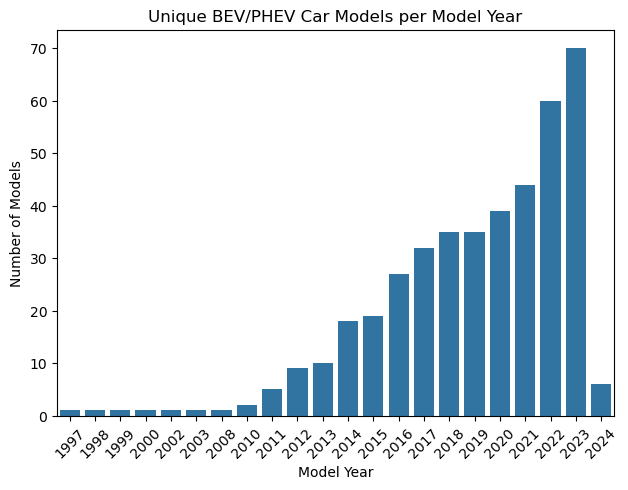

In [10]:
sns.barplot(data=unique_model_per_year)
plt.xticks(rotation=45)
plt.tight_layout()
plt.ylabel("Number of Models")
plt.title('Unique BEV/PHEV Car Models per Model Year')

$$mean = \frac{\sum_{i=1}^{n} x_i}{n}$$

$$median = \begin{cases} x_{\frac{n=1}{2}} & \text{if n is odd} \\ \frac{x_{\frac{n}{2}} + x_{\frac{n}{2}+1}}{2} & \text{if n is even} \end{cases}$$

In [11]:
# Remove all rows with 0 range for better range calculation
bev_df2 = bev_df[bev_df['Electric Range'] != 0]
#print(bev_df2.groupby('Model Year')['Electric Range'].describe())
bev_mean_range = bev_df2.groupby('Model Year')['Electric Range'].mean()
bev_make_range_df = bev_df2.groupby(['Model Year','Make'])['Electric Range'].mean().reset_index()
print(bev_mean_range)

Model Year
1997     39.000000
1998     58.000000
1999     74.000000
2000     58.000000
2002     95.000000
2003     95.000000
2008    220.000000
2010    245.000000
2011     74.658108
2012    103.790875
2013    110.501188
2014    128.378983
2015    120.576902
2016    135.742740
2017    179.824888
2018    209.682055
2019    209.165027
2020    279.943012
2021    190.960663
Name: Electric Range, dtype: float64


In [12]:
# Same as above but for median
bev_median_range = bev_df2.groupby('Model Year')['Electric Range'].median()
bev_median_range_df = bev_df2.groupby(['Model Year','Make'])['Electric Range'].median().reset_index()
print(bev_mean_range)

Model Year
1997     39.000000
1998     58.000000
1999     74.000000
2000     58.000000
2002     95.000000
2003     95.000000
2008    220.000000
2010    245.000000
2011     74.658108
2012    103.790875
2013    110.501188
2014    128.378983
2015    120.576902
2016    135.742740
2017    179.824888
2018    209.682055
2019    209.165027
2020    279.943012
2021    190.960663
Name: Electric Range, dtype: float64


### Simple Barchart of Electric Range by Model Year to show a trend.
### Would be more interesting to see stacked barchart by model...

Text(0.5, 1.0, 'BEV Mean Range by Model Year')

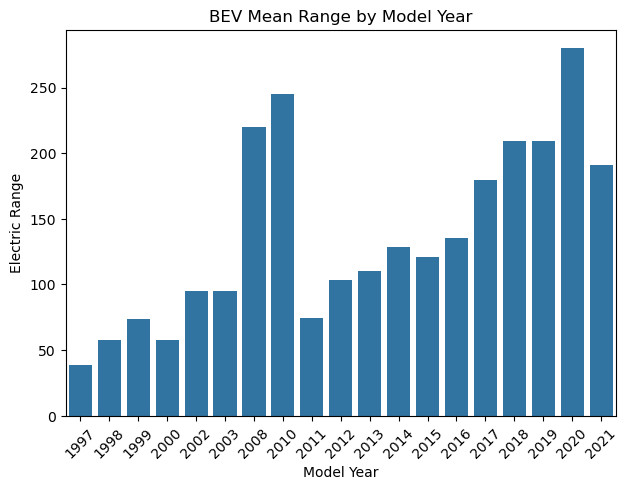

In [13]:
# 
sns.barplot(data=bev_mean_range)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('BEV Mean Range by Model Year')

Text(0.5, 1.0, 'BEV Median Range by Model Year')

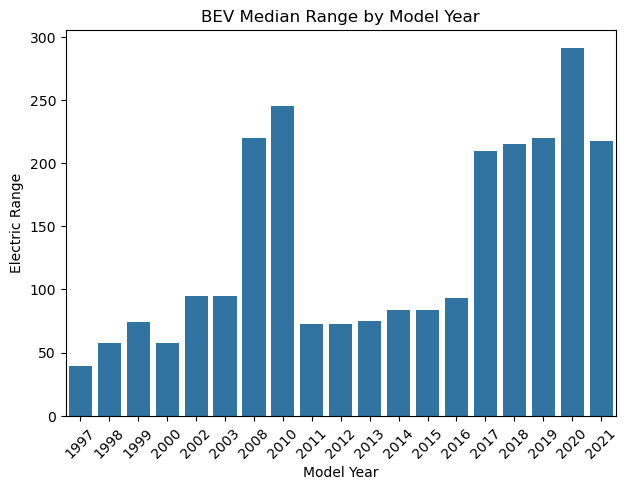

In [14]:
# Same as above chart but with Median
sns.barplot(data=bev_median_range)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('BEV Median Range by Model Year')

### Kind of a weird stacked barchart, need to play with it more. Trying to show where the large means in range are coming from on some of the years (Tesla in 2008,2010)

In [15]:
from matplotlib.colors import ListedColormap

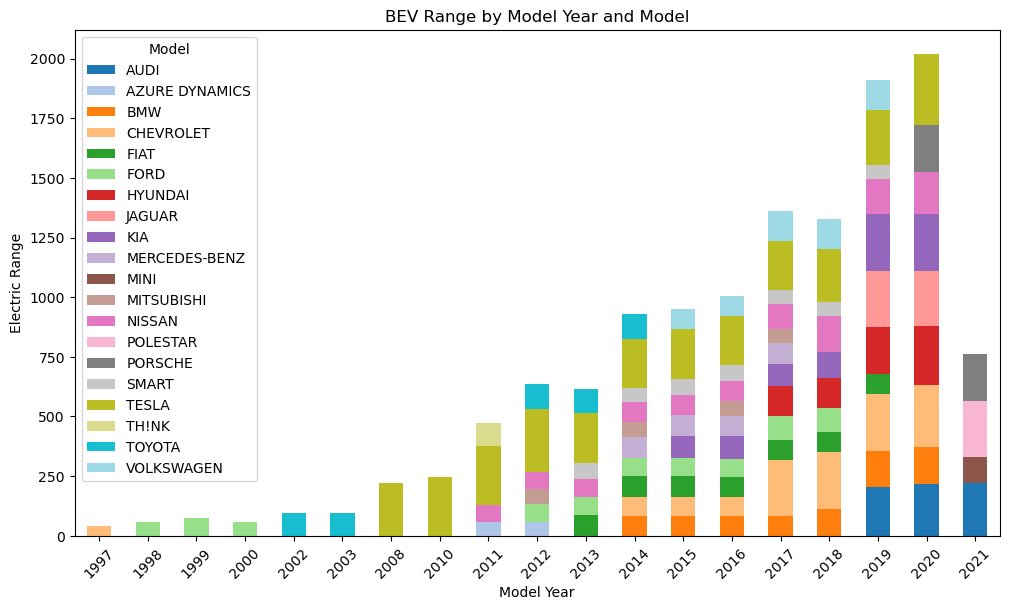

In [51]:
bev_pivot = bev_make_range_df.pivot(index='Model Year', columns='Make', values='Electric Range')
# Using seaborn for the color palette (More options -> make sure each model is unique)
colors = sns.color_palette("tab20", n_colors=len(bev_pivot.columns))  
# convert Seaborn palette to matplotlib colormap (cmap)
cmap = ListedColormap(colors)
ax = bev_pivot.plot(kind='bar', stacked=True, figsize=(10, 6),colormap=cmap )
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('BEV Range by Model Year and Model')
plt.ylabel('Electric Range')
plt.legend(title='Model')
plt.show()



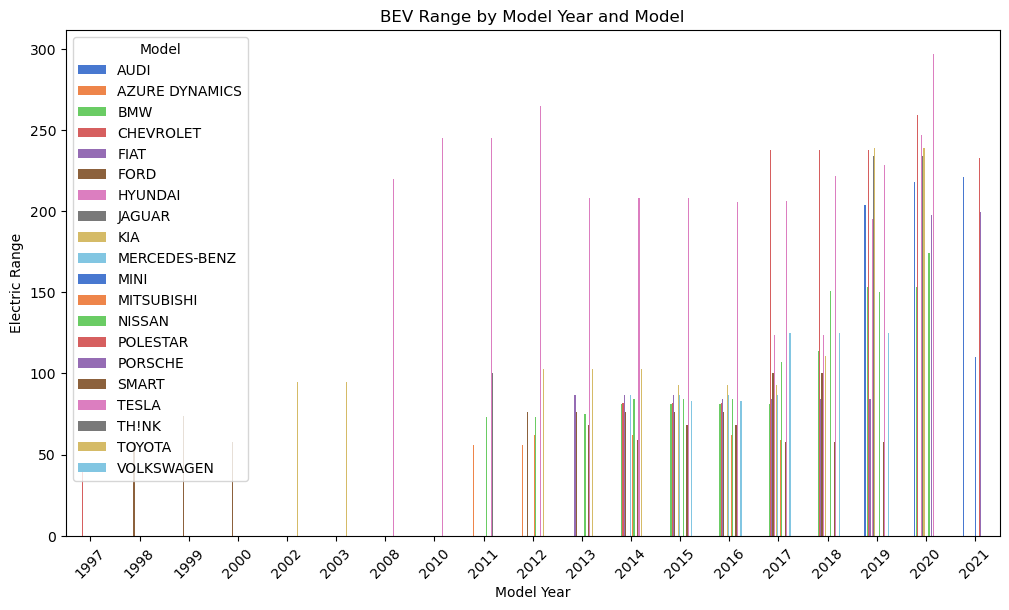

In [17]:
bev_pivot = bev_make_range_df.pivot(index='Model Year', columns='Make', values='Electric Range')
# Using seaborn for the color palette (More options -> make sure each model is unique)
colors = sns.color_palette("muted", n_colors=len(bev_pivot.columns))  
# convert Seaborn palette to matplotlib colormap (cmap)
cmap = ListedColormap(colors)
ax = bev_pivot.plot(kind='bar', stacked=False, figsize=(10, 6),colormap=cmap )
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('BEV Range by Model Year and Model')
plt.ylabel('Electric Range')
plt.legend(title='Model')
plt.show()



In [18]:
# Creating a Panda Series of the unique models in each model year to correlate with the change in range

model_year_series = bev_df2.groupby('Model Year')['Model'].unique()
print(model_year_series)
#print(model_year_series[2020])

Model Year
1997                                        [S-10 PICKUP]
1998                                             [RANGER]
1999                                             [RANGER]
2000                                             [RANGER]
2002                                               [RAV4]
2003                                               [RAV4]
2008                                           [ROADSTER]
2010                                           [ROADSTER]
2011     [LEAF, ROADSTER, CITY, TRANSIT CONNECT ELECTRIC]
2012    [LEAF, MODEL S, I-MIEV, FOCUS, TRANSIT CONNECT...
2013    [MODEL S, LEAF, RAV4, 500, FOCUS, FORTWO ELECT...
2014    [I3, FOCUS, LEAF, MODEL S, 500, I-MIEV, B-CLAS...
2015    [500, LEAF, I3, MODEL S, E-GOLF, FORTWO ELECTR...
2016    [500, MODEL X, LEAF, E-GOLF, SPARK, MODEL S, S...
2017    [LEAF, I3, MODEL S, BOLT EV, 500, MODEL X, FOR...
2018    [LEAF, MODEL 3, MODEL X, MODEL S, I3, BOLT EV,...
2019    [MODEL 3, NIRO, LEAF, E-TRON, MODEL X, BOLT EV...
202

In [19]:
# Series with models/model year as index, range as the values
bev_df2.groupby('Model')[['Electric Range','Model Year']].describe()
bev_models = bev_df2.groupby(['Model','Model Year'])['Electric Range'].mean().sort_values(ascending=False)
bev_models


Model                     Model Year
MODEL S                   2020          331.346835
MODEL 3                   2020          297.812636
MODEL X                   2020          291.635945
MODEL Y                   2020          291.000000
MODEL X                   2019          289.000000
                                           ...    
RANGER                    1998           58.000000
FORTWO                    2017           57.970588
TRANSIT CONNECT ELECTRIC  2011           56.000000
                          2012           56.000000
S-10 PICKUP               1997           39.000000
Name: Electric Range, Length: 114, dtype: float64

In [20]:
# Same as above, but without the 0 ranges removed
# Lots of newer models that are missing the range - really ruins the dataset
bev_df.groupby('Model')[['Electric Range','Model Year']].describe()
bev_models = bev_df.groupby(['Model','Model Year'])['Electric Range'].mean().sort_values(ascending=False)
bev_models


Model    Model Year
MODEL S  2020          331.346835
MODEL 3  2020          297.812636
MODEL X  2020          291.635945
MODEL Y  2020          291.000000
MODEL X  2019          289.000000
                          ...    
I-PACE   2023            0.000000
         2022            0.000000
         2021            0.000000
HARDTOP  2024            0.000000
XC40     2023            0.000000
Name: Electric Range, Length: 210, dtype: float64

In [21]:
# This is an interesting dataset looking at how the mean range changed, seems like there might be some 0s
# the dataset though
# Need to filter by Plug-in hybrid as well
print(bev_df.groupby('Model Year')['Electric Range'].describe())
print(bev_df.groupby('Model Year')['Electric Range'].median())
bev_range_mean = bev_df.groupby('Model Year')['Electric Range'].mean()


              count        mean        std    min    25%    50%    75%    max
Model Year                                                                   
1997            1.0   39.000000        NaN   39.0   39.0   39.0   39.0   39.0
1998            1.0   58.000000        NaN   58.0   58.0   58.0   58.0   58.0
1999            4.0   74.000000   0.000000   74.0   74.0   74.0   74.0   74.0
2000            9.0   58.000000   0.000000   58.0   58.0   58.0   58.0   58.0
2002            2.0   95.000000   0.000000   95.0   95.0   95.0   95.0   95.0
2003            1.0   95.000000        NaN   95.0   95.0   95.0   95.0   95.0
2008           19.0  220.000000   0.000000  220.0  220.0  220.0  220.0  220.0
2010           20.0  245.000000   0.000000  245.0  245.0  245.0  245.0  245.0
2011          740.0   74.658108  16.833761   56.0   73.0   73.0   73.0  245.0
2012          789.0  103.790875  70.813282   56.0   73.0   73.0   73.0  265.0
2013         2945.0  110.501188  58.267789   68.0   75.0   75.0 

In [22]:
model20201_df = df[df['Model Year'] == 2021]
model20201_df.head()

,County,City,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Electric Range,Base MSRP,Legislative District,2020 Census Tract,Longitude,latitude
7,Snohomish,Edmonds,98026,2021,AUDI,Q5 E,Plug-in Hybrid Electric Vehicle,18,0,21,53061050300,-122.335685,47.803720
20,Snohomish,Lake Stevens,98258,2021,AUDI,Q5 E,Plug-in Hybrid Electric Vehicle,18,0,44,53061052607,-122.112065,48.004345
33,Whitman,Pullman,99163,2021,HYUNDAI,IONIQ,Plug-in Hybrid Electric Vehicle,29,0,9,53075000601,-117.179120,46.730885
49,Skagit,Anacortes,98221,2021,BMW,X3,Plug-in Hybrid Electric Vehicle,17,0,40,53057940600,-122.615305,48.501275
124,Island,Langley,98260,2021,TESLA,MODEL Y,Battery Electric Vehicle,0,0,10,53029972000,-122.408015,48.035570


## Mapping Registration Locations using Lat/Long
Uses Contextily for basemap
Use Geopandas for other mapping

<Axes: xlabel='Longitude', ylabel='latitude'>

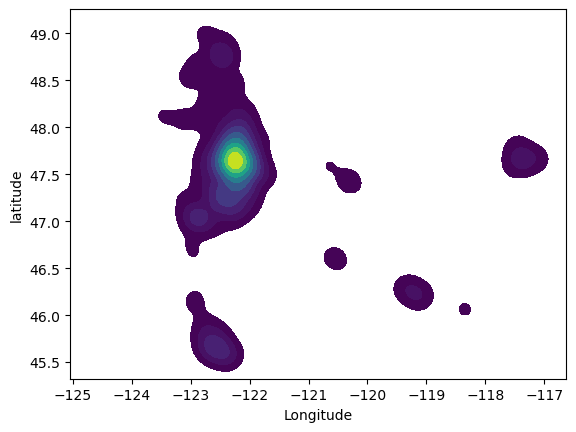

In [23]:
sns.kdeplot(x='Longitude', y='latitude', data=bev_df, fill=True, cmap='viridis')

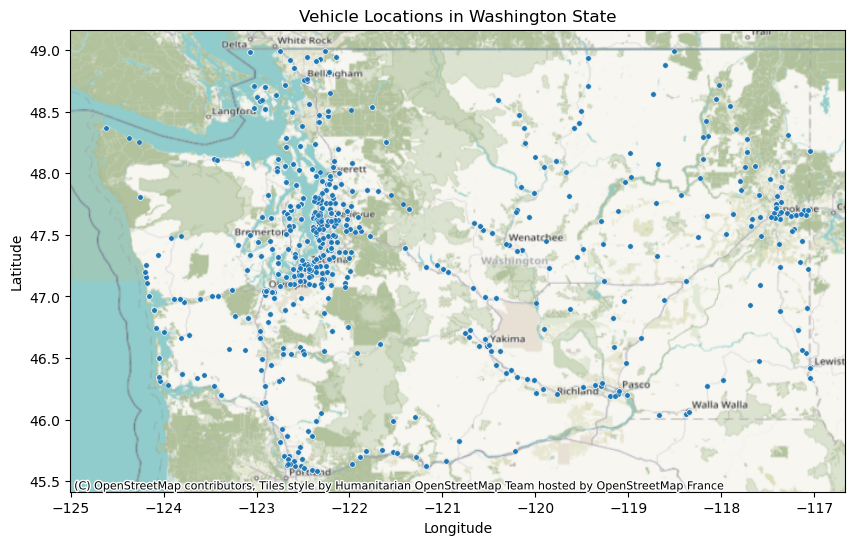

In [24]:
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Longitude', y='latitude', data=bev_df, s=15)
ctx.add_basemap(ax, crs="EPSG:4326")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vehicle Locations in Washington State')
plt.savefig("./figures/BEV_location_map.png")
plt.show()



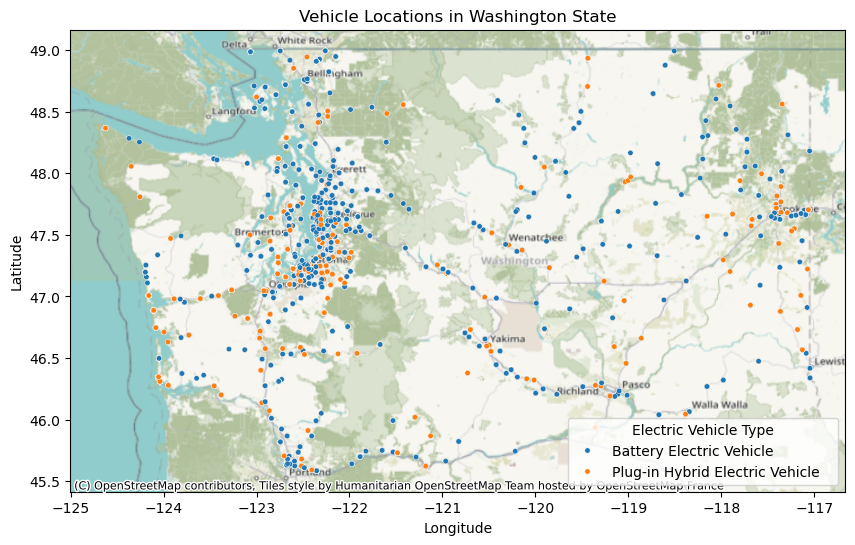

In [25]:
# Scatterplot with BEV and Plugin to see distribution differences
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(x='Longitude', y='latitude', data=df, s=15, hue='Electric Vehicle Type')
ctx.add_basemap(ax, crs="EPSG:4326")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vehicle Locations in Washington State')
plt.savefig("./figures/BEV_and_PHEV_map.png")
plt.show()


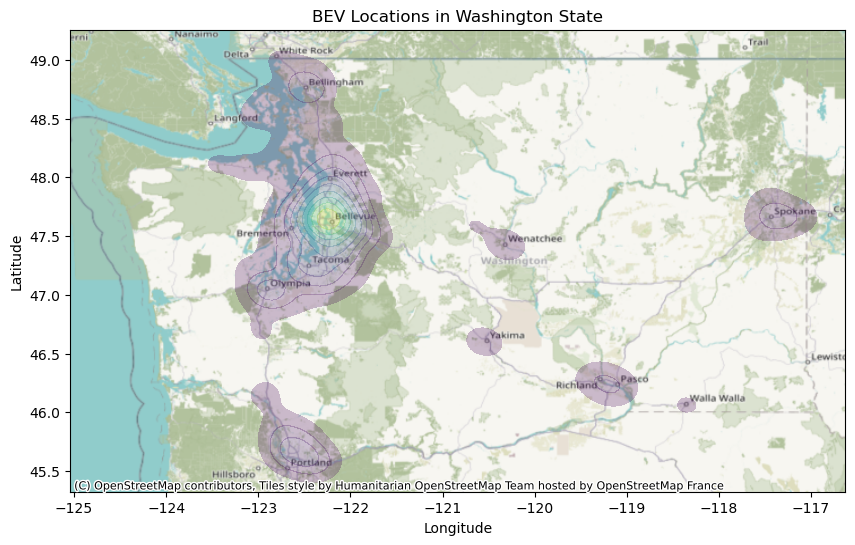

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.kdeplot(x='Longitude', y='latitude', data=bev_df, fill=True, cmap='viridis', alpha=0.25)
ctx.add_basemap(ax, crs="EPSG:4326")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('BEV Locations in Washington State')
plt.savefig("./figures/BEV_density_map.png")
plt.show()


In [27]:
# Looking at Base MSRP values that aren't just 0, grouping by model

df['Base MSRP'].value_counts()
msrp_df =df[df['Base MSRP'] != 0]
msrp_df.groupby('Model')['Base MSRP'].mean()

Model
330E           44693.956044
530E           54381.993007
740E           90382.000000
918           845000.000000
CAYENNE        81100.000000
COUNTRYMAN     36867.114094
CROSSTREK      34995.000000
CT6            75095.000000
KARMA         102000.000000
MODEL S        69084.328838
PACIFICA       39995.000000
PANAMERA      184400.000000
ROADSTER      105696.739130
SOUL           31950.000000
SOUL EV        32806.637168
WHEEGO         32995.000000
XC60           52900.000000
XC90           64950.000000
Name: Base MSRP, dtype: float64

In [28]:
# Same as above but for BEV only
# Very few BEVs actually have MSRP information.
bev_df['Base MSRP'].value_counts()
msrp_bev_df =bev_df[bev_df['Base MSRP'] != 0]
msrp_bev_df.groupby('Model')['Base MSRP'].mean()

Model
MODEL S      69084.328838
ROADSTER    105696.739130
SOUL         31950.000000
SOUL EV      32806.637168
Name: Base MSRP, dtype: float64

In [29]:
districts = gpd.read_file('./data/Washington_State_Legislative_Districts_2024.shp')
districts.head()

,FID,District,Shape__Are,Shape__Len,geometry
0,1,1,1.508509e+09,2.888039e+05,"POLYGON ((1216090.427 918835.499, 1216075.331 ..."
1,2,2,2.818481e+10,1.305465e+06,"POLYGON ((1171718.556 656566.26, 1172038.049 6..."
2,3,3,1.152137e+09,2.269569e+05,"POLYGON ((2391942.594 888719.494, 2392008.111 ..."
3,4,4,1.111762e+10,5.943962e+05,"POLYGON ((2415454.936 1005106.945, 2415484.777..."
4,5,5,2.153821e+10,1.070660e+06,"POLYGON ((1279696.354 826524.919, 1280433.448 ..."


In [30]:
district_counts = bev_df2.groupby('Legislative District').size().reset_index(name='Vehicle Count')
merged_data = districts.merge(district_counts, left_on='District', right_on='Legislative District')

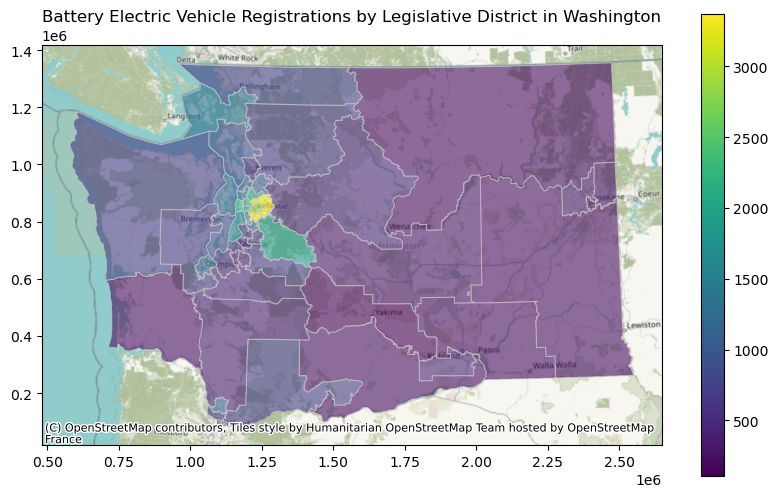

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
merged_data.plot(column='Vehicle Count', cmap='viridis', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, alpha = 0.6)
ax.set_title('Battery Electric Vehicle Registrations by Legislative District in Washington')
ctx.add_basemap(ax, crs=merged_data.crs.to_string())
plt.savefig("./figures/district_map.png")
plt.show()
